In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import nltk, warnings
import itertools
from statistics import mean
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from numpy import where
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#get access to data in google drive
year_full=pd.read_csv('/content/drive/MyDrive/pricing_hackathon_checks_train.csv', header=None)
year_full.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,644474c3d41185fa4c4f427095954f06,20191017,d2ac32e14d651b9ed03f26f845a11597,f0478c7f392532b5b9843e144a31cb78,14:35:26,98f463552b07d49686c8be996251c778,7215ee9c7d9dc229d2921a40e899ec5f,4,1.000,24.94,48.09,2.60,7e35e74e610188414ad24235dd787c78
1,644474c3d41185fa4c4f427095954f06,20191017,d2ac32e14d651b9ed03f26f845a11597,f0478c7f392532b5b9843e144a31cb78,14:35:26,b75147feae4cf8ec07fb5f2cef855def,7215ee9c7d9dc229d2921a40e899ec5f,1,1.000,1.14,3.79,0.20,7e35e74e610188414ad24235dd787c78
2,644474c3d41185fa4c4f427095954f06,20191017,d2ac32e14d651b9ed03f26f845a11597,f0478c7f392532b5b9843e144a31cb78,14:35:26,16b4bff70d409ddb77c8107a528cf94b,7215ee9c7d9dc229d2921a40e899ec5f,8,1.000,85.18,198.18,10.61,7e35e74e610188414ad24235dd787c78
3,644474c3d41185fa4c4f427095954f06,20191017,d2ac32e14d651b9ed03f26f845a11597,f0478c7f392532b5b9843e144a31cb78,14:35:26,b0fc4f923bae05bf1276315a8efae07c,7215ee9c7d9dc229d2921a40e899ec5f,3,1.000,29.17,99.99,5.30,7e35e74e610188414ad24235dd787c78
4,644474c3d41185fa4c4f427095954f06,20191017,d2ac32e14d651b9ed03f26f845a11597,f0478c7f392532b5b9843e144a31cb78,14:35:26,f0c13fc65a011d296e01626c0c2649d0,e0ceb21aca7b78a5ea6418b0c28e9c95,5,1.476,157.66,174.79,58.26,7e35e74e610188414ad24235dd787c78


In [ ]:
# Remove unnecessary columns
year_full.columns= ['client_id','date', 'shop_id', 'check_id','time', 'sku', 'promo_id', 'check_pos', 'num_of_sales', 'supplier_price', 'selling_price', 'discount', 'region_name']
year_full=year_full.drop(['promo_id', 'shop_id', 'time', 'sku', 'check_pos', 'supplier_price','discount', 'region_name'], axis=1)
year_full.rename(columns={'date': 'day'}, inplace=True)
year_full.head()


,client_id,date,check_id,num_of_sales,selling_price
0,644474c3d41185fa4c4f427095954f06,20191017,f0478c7f392532b5b9843e144a31cb78,1.000,48.09
1,644474c3d41185fa4c4f427095954f06,20191017,f0478c7f392532b5b9843e144a31cb78,1.000,3.79
2,644474c3d41185fa4c4f427095954f06,20191017,f0478c7f392532b5b9843e144a31cb78,1.000,198.18
3,644474c3d41185fa4c4f427095954f06,20191017,f0478c7f392532b5b9843e144a31cb78,1.000,99.99
4,644474c3d41185fa4c4f427095954f06,20191017,f0478c7f392532b5b9843e144a31cb78,1.476,174.79


In [ ]:
#convert data to datetime type
year_full['day']=year_full['day'].astype(str)
year_full['day'] = year_full['day'].apply(lambda x: dt.datetime.strptime(x,'%Y%m%d'))
year_full.head()

,client_id,day,check_id,num_of_sales,selling_price
0,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,1.000,48.09
1,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,1.000,3.79
2,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,1.000,198.18
3,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,1.000,99.99
4,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,1.476,174.79


In [ ]:
#mark months in order from 1 to 24 (for 2 years of analysis)
year_copy_19=year_full[(year_full['day']>=dt.datetime(2019,1,1)) & (year_full['day'] <=dt.datetime(2019,12,31))]
year_copy_20=year_full[(year_full['day']>dt.datetime(2019,12,31)) & (year_full['day']<dt.datetime(2021,1,1))]

year_copy_19['month']=[i.month for i in year_copy_19['day']]
year_copy_20['month']=[i.month+12 for i in year_copy_20['day']]

year = pd.concat([year_copy_19, year_copy_20], ignore_index=True)

In [ ]:
#calculate revenue
year['revenue']=year['num_of_sales']*year['selling_price']

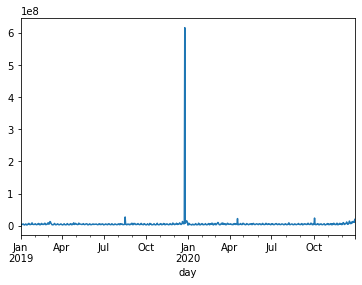

In [ ]:
#distribution of revenue
year.groupby(['day'])['revenue'].sum().plot()

In [ ]:
year=year.drop(['selling_price', 'num_of_sales'], axis=1)

In [ ]:
#eliminate outliers - customers with extremely high revenues (> 98 percentile)
year1=year.groupby(['client_id','check_id']).agg({'revenue':'sum'})
P = np.percentile(year1.revenue, [0, 98])
year1 = year1[(year1.revenue > P[0]) & (year1.revenue < P[1])]
year1=year1.reset_index()
year_n=year.merge(year1, on=['client_id','check_id'], how='inner')
year_n.head()

,client_id,day,check_id,month,revenue_x,revenue_y
0,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,10,48.09000,902.36004
1,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,10,3.79000,902.36004
2,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,10,198.18000,902.36004
3,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,10,99.99000,902.36004
4,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,10,257.99004,902.36004


In [ ]:
#eliminate customers who made < 5 purchases
year2=year_n.groupby(['client_id']).agg({'check_id':'nunique'})
only_5=year2[year2['check_id']>=5]
only_5=only_5.reset_index()
year_n_5=year_n.merge(only_5, on='client_id', how='inner')
year_n_5.head()

,client_id,day,check_id_x,month,revenue_x,revenue_y,check_id_y
0,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,10,48.09000,902.36004,174
1,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,10,3.79000,902.36004,174
2,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,10,198.18000,902.36004,174
3,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,10,99.99000,902.36004,174
4,644474c3d41185fa4c4f427095954f06,2019-10-17,f0478c7f392532b5b9843e144a31cb78,10,257.99004,902.36004,174


In [ ]:
year_n_5=year_n_5.drop_duplicates(subset=['client_id', 'check_id_x'])
year_n_5=year_n_5.drop(['revenue_x', 'check_id_y'], axis=1)

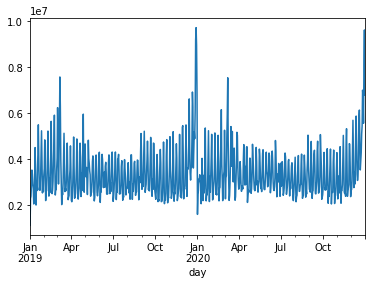

In [ ]:
#revenue after deleting outliers
year_n_5.groupby(['day'])['revenue_y'].sum().plot()

In [ ]:
year_n_5.shape

(1176203, 6)

In [ ]:
# number of unique clients after deleting outliers
year_n_5['client_id'].nunique()

33918

In [9]:
#rename columns
#"week" means "month" actually
year_n_5['day'] = pd.to_datetime(year_n_5['day'])
year_n_5.columns=['0','client_id', 'day', 'check_id', 'week', 'revenue']

In [ ]:
#save the result
year_n_5.to_csv('data_for_clustering.csv')